In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import os
from PIL import Image
from utils import tileImage, padImage

In [3]:
# mask_path = "C:\\Users\\tcuri\\Documents\\_UC Merced Documents\\research\\insite\\image_data\\steve_data\\cc7_masks\\265\\"
img_path = "C:\\Users\\tcuri\\Documents\\_UC Merced Documents\\research\\insite\\2023.11.10-20240821T211750Z-001\\CC7.315.3_2023.11.10.png"
# "C:\Users\tcuri\Documents\_UC Merced Documents\research\insite\2023.11.10-20240821T211750Z-001\CC7.315.3_2023.11.10.png"
img = cv2.imread(img_path)

# tile_size = 256
# for mask_file in os.listdir(os.path.join(img_path)):
#     mask = np.array(Image.open(os.path.join(img_path, mask_file)).convert("L"), dtype=np.float32)
#     mask = padImage(mask, tile_size)

#     mask_tiles = tileImage(mask, tile_size)
    
#     num_bg_tiles = 0
#     for tile in mask_tiles:
#         if not np.any(tile):
#             num_bg_tiles += 1
#             # plt.imshow(tile, cmap='binary_r'); plt.show(); break #sanity check
            
#     print(f"Number of background tiles in {mask_file}: {num_bg_tiles} / {len(mask_tiles)}")

#     break

(1080, 1920, 3)


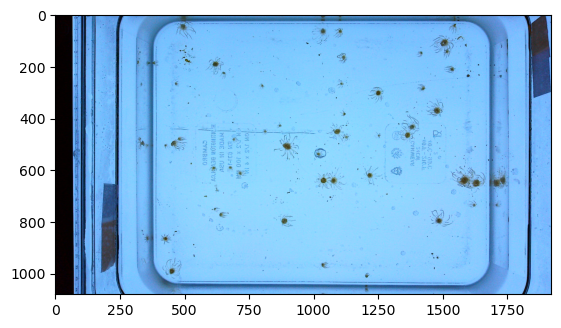

(1280, 2048, 3)


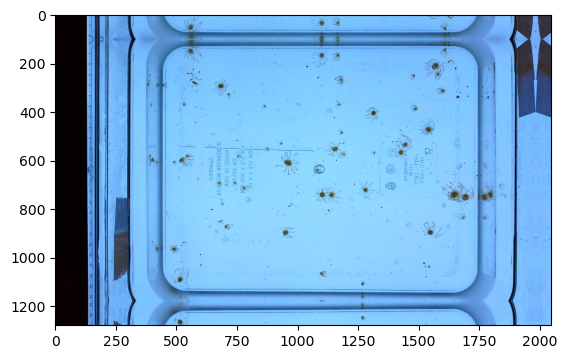

In [41]:
tile_size = 256
img = cv2.imread(img_path); print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #converting to RGB
plt.imshow(img); plt.show()
padded_img = padImage(img, tile_size=tile_size) #padding img st both H, W are divisible by tile size
print(padded_img.shape)
plt.imshow(padded_img); plt.show()

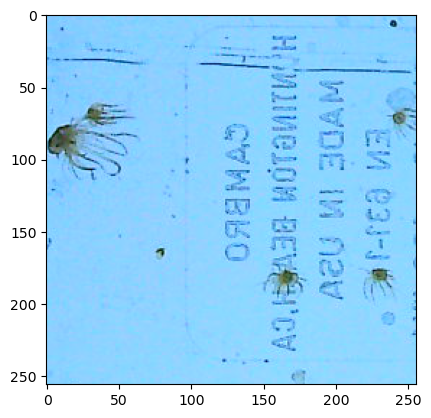

In [7]:
img_tiles = tileImage(padded_img, tile_size) #tiling padded image
plt.imshow(img_tiles[18]); plt.show()

In [38]:
#function to "stitch" tiles back together 
def stitchTiles(tiles: list[np.ndarray], img_shape: tuple[int], overlap: bool = False) -> np.ndarray:
    """
    Input: 
    - tiles: list of tiles 
    - img_shape: shape of tiled image (after padding)
    - overlap: booleann flag for if tiles are overlapping
    """
    img = np.zeros(shape=img_shape, dtype=np.uint8) #initializing array of zeros

    #TODO: add check to confirm H,W are not indices 2,3 (i.e. shape = C x H x W)
    H = img_shape[0]; W = img_shape[1] #storing height/width 
    tile_size = tiles[0].shape[0] #size of tiles TODO: confirm all tiles are square and same size

    #number of tiles along height and width
    tiles_H = math.ceil(H / tile_size) 
    tiles_W = math.ceil(W / tile_size)

    tile_idx = 0 #used to index tiles below

    #looping over height of image (rows)
    for i in range(tiles_H):
        #looping over width of image (cols)
        for j in range(tiles_W):
            img[i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size] = tiles[tile_idx] #setting image region to tile

            tile_idx += 1 #incrementing index

    return img

stitched_img = stitchTiles(tiles=img_tiles, img_shape=padded_img.shape)
np.all(padded_img == stitched_img) #sanity check

True

In [47]:
def unpadImage(img: np.ndarray, img_shape: tuple[int], tile_size: int = 256) -> np.ndarray:
    """
    Input: 
    - img: image to unpad 
    - img_shape: shape of image after unpadding (i.e. original image)
    - overlap: booleann flag for if tiles are overlapping
    """

    unpadded_img = np.zeros(img_shape, dtype=np.uint8)

    H = img_shape[0]; W = img_shape[1] #dimensions of original unpadded image
    padded_H = img.shape[0]; padded_W = img.shape[1] #dimensions of padded image

    #amount of padding on each side of height/width respectively
    H_pad = (tile_size*math.ceil(H / tile_size) - H) // 2
    W_pad = (tile_size*math.ceil(W / tile_size) - W) // 2

    #if image was padded, then unpad
    if H_pad != 0 or W_pad != 0:
        unpadded_img = img[H_pad:(padded_H - H_pad), W_pad:(padded_W - W_pad)] #storing unpadded image

    #TODO: should we store a new variable or just return the above
    return unpadded_img 

unpadded_img = unpadImage(img=stitched_img, img_shape=img.shape, tile_size=tile_size)
unpadded_img.shape

(1080, 1920, 3)

In [55]:
test = np.zeros(shape=(256, 256, 3))

print(test[0, 0])

[0. 0. 0.]


True


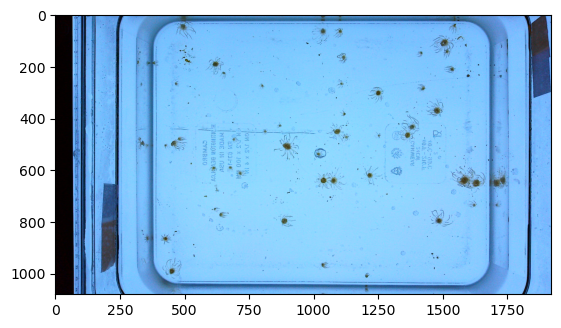

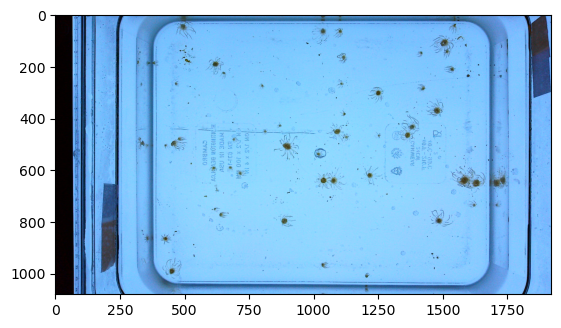

In [50]:
print(np.all(unpadded_img == img))
plt.imshow(unpadded_img); plt.show()
plt.imshow(img); plt.show()

In [2]:
img_path = "C:\\Users\\giant\\Desktop\\aiptasia\\data\\carvana_data\\subset"
mask_path = "C:\\Users\\giant\\Desktop\\aiptasia\\data\\carvana_data\\subset_masks"
file_name = sorted(os.listdir(img_path))[0]; mask_file_name = sorted(os.listdir(mask_path))[0]
img = cv2.imread(os.path.join(img_path, file_name)); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# mask = cv2.imread(os.path.join(mask_path, mask_file_name))
mask = np.array(Image.open(os.path.join(mask_path, mask_file_name)).convert("L"), dtype=np.float32)

#function to pad an image such that its dimensions are divisible by a given tile size
def padImage(img, tile_size):
    H, W = img.shape[:2] #height/width of original image

    H_pad = 0
    if H % tile_size != 0: 
        H_pad = (tile_size*math.ceil(H / tile_size) - H) // 2

    W_pad = 0
    if W % tile_size != 0:
        W_pad = (tile_size*math.ceil(W / tile_size) - W) // 2

    img = cv2.copyMakeBorder(src=img, top=H_pad, bottom=H_pad, left=W_pad, right=W_pad, borderType=cv2.BORDER_REFLECT)

    return img

#function to read and store an image as a numpy array
def readImage(img_path: str, mask: bool = False) -> np.ndarray:
    if mask: #binary mask image
        img = np.array(Image.open(img_path).convert("L"), dtype=np.float32)
    else: #raw image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

In [ ]:
def stitchTiles(tiles: list[np.ndarray], img_shape: tuple[int]) -> np.ndarray:
    stiched_img = np.zeros(shape=img_shape, dtype=tiles[0].dtype) #initializing array of zeros as full size of image

    tile_size = tiles[0].shape[0] #size of tiles
    img_height = img_shape[0]; img_width = img_shape[1] #image height/width
    
    #getting number of tiles along height/width
    tiles_height = math.floor(img_height / tile_size)
    if (img_height % tile_size) != 0: tiles_height += 1 #incrementing if not divisble
    tiles_width = math.floor(img_width / tile_size)
    if (img_width % tile_size) != 0: tiles_width += 1 #incrementing if not divisble
    
    i = 0 #iterator

    for h_tile in range(tiles_height):
        for w_tile in range(tiles_width):
            tile_top = h_tile*tile_size
            tile_bottom = (h_tile + 1)*tile_size
            tile_left = w_tile*tile_size
            tile_right = (w_tile + 1)*tile_size

            #check to avoid tile doesn't surpass image height
            if tile_bottom > img.shape[0]:
                tile_bottom = img.shape[0]
                # tile_top = tile_bottom - tile_size
            
            #check to avoid tile doesn't surpass image width
            if tile_right > img.shape[1]: 
                tile_right = img.shape[1]
                # tile_left = tile_right - tile_size

            print(i, tile_top, tile_bottom, tile_left, tile_right)
            stiched_img[tile_top:tile_bottom, tile_left:tile_right, :] = tiles[i][:(tile_bottom - tile_top), :(tile_right - tile_left), :]
            i += 1
    
    return stiched_img

stiched_img = stitchTiles(tiles=tiles, img_shape=img.shape)
plt.imshow(stiched_img); plt.show()

In [ ]:
plt.imshow(tiles[2][(1000 - 80):, :, :])
plt.show()

In [ ]:
test = np.zeros(shape=img.shape, dtype='uint8')
test[:1000, :1000, :] = tiles[0]
plt.imshow(test)
plt.show()

In [ ]:
# ###Do we disregard (i.e. not process) a tile if it does not contain aiptasia?
# plt.imshow(img[0:tile_size, 0:tile_size, :])
# plt.show()
# plt.clf()

# plt.imshow(img[0:tile_size, tile_size:2*tile_size, :])
# plt.show()
# plt.clf()

In [ ]:
for tile in tiles:
    plt.imshow(tile)
    plt.show()
    plt.clf()

In [ ]:
import platform

#storing image and mask directories
if platform.system() == "Linux":
    root_dir = "/home/pcuriel/data/aiptasia/image_data/water_body_data/"
    image_dir = root_dir + "Images"
    mask_dir = root_dir + "Masks"
elif platform.system() == "Windows": 
    root_dir = "C:\\Users\\giant\\Desktop\\aiptasia\\data\\carvana_data"
    image_dir = root_dir + "\\train"
    mask_dir = root_dir + "\\train_masks"